# Deep Learning Models for Univariate Time Series Forecasting
##### Written by Jason Brownlee 
###### Edited by Michael Locker

Deep learning neural networks are capable of automatically learning and extracting features from raw data.

This feature of neural networks can be used for time series forecasting problems, where models can be developed directly on the raw observations without the direct need to scale the data using normalization and standardization or to make the data stationary by differencing.

Impressively, simple deep learning neural network models are capable of making skillful forecasts as compared to naive models and tuned SARIMA models on univariate time series forecasting problems that have both trend and seasonal components with no pre-processing.

In this tutorial, you will discover how to develop a suite of deep learning models for univariate time series forecasting.

After completing this tutorial, you will know:

* How to develop a robust test harness using walk-forward validation for evaluating the performance of neural network models.

* How to develop and evaluate simple multilayer Perceptron and convolutional neural networks for time series forecasting.

* How to develop and evaluate LSTMs, CNN-LSTMs, and ConvLSTM neural network models for time series forecasting.

Kick-start your project with my new book Deep Learning for Time Series Forecasting, including step-by-step tutorials and the Python source code files for all examples.

Let’s get started.

In [1]:
# This is some clean up code that should ensure the script runs virtually anywhere
%%capture

import os

try:
    import google.colab

except:
    try:
        import gdown
    except:
        !pip install gdown
    try:
        import tensorflow
    except:
        !pip install tensorflow --user
    try:
        import keras
    except:
        !pip install keras
try:
    series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
except:
# This downloads the dataset from my google drive
    !gdown https://drive.google.com/uc?id=1rVNDsLgmNR3l1Us8HnKE3tRPrdlyM9p6

In [2]:
# Import our library needs
from math import sqrt
from numpy import mean
from numpy import median
from numpy import std
from numpy import array
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from matplotlib import pyplot

#### Tutorial Overview
This tutorial is divided into five parts; they are:

1. Problem Description
2. Model Evaluation Test Harness
3. Multilayer Perceptron Model
4. Convolutional Neural Network Model
5. Recurrent Neural Network Models

#### Problem Description
The ‘monthly car sales‘ dataset summarizes the monthly car sales in Quebec, Canada between 1960 and 1968.

We can load this dataset as a Pandas series using the function read_csv().

In [3]:
# load
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)

Once loaded, we can summarize the shape of the dataset in order to determine the number of observations.

In [4]:
# summarize shape
print(series.shape)

(108, 1)


We can then create a line plot of the series to get an idea of the structure of the series.

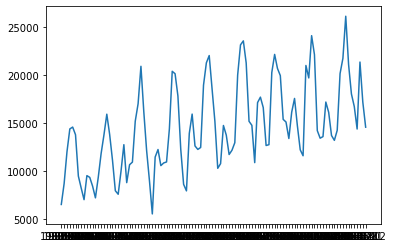

In [5]:
# plot
pyplot.plot(series)
pyplot.show()

We can tie all of this together; the complete example is listed below.

(108, 1)


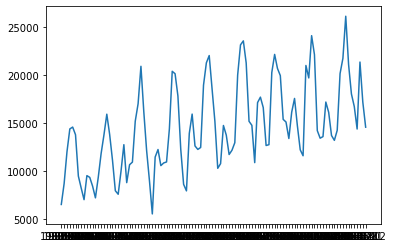

In [6]:
# load and plot dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.show()

Running the example first prints the shape of the dataset

The dataset is monthly and has nine years, or 108 observations. In our testing, will use the last year, or 12 observations, as the test set.

A line plot is created. The dataset has an obvious trend and seasonal component. The period of the seasonal component could be six months or 12 months.

Where the negative indexes refer to observations in the series relative to the end of the historical data for the month being predicted.

From prior experiments, we know that a SARIMA model can achieve an RMSE of 1551.842 with the configuration of SARIMA(0, 0, 0),(1, 1, 0),12 where no elements are specified for the trend and a seasonal difference with a period of 12 is calculated and an AR model of one season is used.

The performance of the naive model provides a lower bound on a model that is considered skillful. Any model that achieves a predictive performance of lower than 1841.155 on the last 12 months has skill.

The performance of the SARIMA model provides a measure of a good model on the problem. Any model that achieves a predictive performance lower than 1551.842 on the last 12 months should be adopted over a SARIMA model.

Now that we have defined our problem and expectations of model skill, we can look at defining the test harness.

## Model Evaluation Test Harness

In this section, we will develop a test harness for developing and evaluating different types of neural network models for univariate time series forecasting.

This section is divided into the following parts:

1. Train-Test Split
2. Series as Supervised Learning
3. Walk-Forward Validation
4. Repeat Evaluation
5. Summarize Performance
6. Worked Example

#### Train-Test Split
The first step is to split the loaded series into train and test sets.

We will use the first eight years (96 observations) for training and the last 12 for the test set.

The train_test_split() function below will split the series taking the raw observations and the number of observations to use in the test set as arguments.

In [7]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

#### Series as Supervised Learning
Next, we need to be able to frame the univariate series of observations as a supervised learning problem so that we can train neural network models.

A supervised learning framing of a series means that the data needs to be split into multiple examples that the model learn from and generalize across.

Each sample must have both an input component and an output component.

The input component will be some number of prior observations, such as three years or 36 time steps.

The output component will be the total sales in the next month because we are interested in developing a model to make one-step forecasts.

We can implement this using the shift() function on the pandas DataFrame. It allows us to shift a column down (forward in time) or back (backward in time). We can take the series as a column of data, then create multiple copies of the column, shifted forward or backward in time in order to create the samples with the input and output elements we require.

When a series is shifted down, NaN values are introduced because we don’t have values beyond the start of the series.

We can see that on the second row, the value 1 is provided as input as an observation at the prior time step, and 2 is the next value in the series that can be predicted, or learned by the model to be predicted when 1 is presented as input.

Rows with NaN values can be removed.

The series_to_supervised() function below implements this behavior, allowing you to specify the number of lag observations to use in the input and the number to use in the output for each sample. It will also remove rows that have NaN values as they cannot be used to train or test a model.

In [8]:
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

#### Walk-Forward Validation
Time series forecasting models can be evaluated on a test set using walk-forward validation.

Walk-forward validation is an approach where the model makes a forecast for each observation in the test dataset one at a time. After each forecast is made for a time step in the test dataset, the true observation for the forecast is added to the test dataset and made available to the model.

Simpler models can be refit with the observation prior to making the subsequent prediction. More complex models, such as neural networks, are not refit given the much greater computational cost.

Nevertheless, the true observation for the time step can then be used as part of the input for making the prediction on the next time step.

First, the dataset is split into train and test sets. We will call the train_test_split() function to perform this split and pass in the pre-specified number of observations to use as the test data.

A model will be fit once on the training dataset for a given configuration.

We will define a generic model_fit() function to perform this operation that can be filled in for the given type of neural network that we may be interested in later. The function takes the training dataset and the model configuration and returns the fit model ready for making predictions.

In [9]:
# fit a model
def model_fit(train, config):
    return None

Each time step of the test dataset is enumerated. A prediction is made using the fit model.

Again, we will define a generic function named model_predict() that takes the fit model, the history, and the model configuration and makes a single one-step prediction.

In [10]:
# # forecast with a pre-fit model
# def model_predict(model, history, config):
#     return 0.0

# forecast with a pre-fit model
def model_predict(model, history, config):
    values = list()
    for offset in config:
        values.append(history[-offset])
    return median(values)

The prediction is added to a list of predictions and the true observation from the test set is added to a list of observations that was seeded with all observations from the training dataset. This list is built up during each step in the walk-forward validation, allowing the model to make a one-step prediction using the most recent history.

All of the predictions can then be compared to the true values in the test set and an error measure calculated.

We will calculate the root mean squared error, or RMSE, between predictions and the true values.

RMSE is calculated as the square root of the average of the squared differences between the forecasts and the actual values. The measure_rmse() implements this below using the mean_squared_error() scikit-learn function to first calculate the mean squared error, or MSE, before calculating the square root.

In [11]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

The complete walk_forward_validation() function that ties all of this together is listed below.

It takes the dataset, the number of observations to use as the test set, and the configuration for the model, and returns the RMSE for the model performance on the test set.

In [12]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

#### Repeat Evaluation
Neural network models are stochastic.

This means that, given the same model configuration and the same training dataset, a different internal set of weights will result each time the model is trained that will in turn have a different performance.

This is a benefit, allowing the model to be adaptive and find high performing configurations to complex problems.

It is also a problem when evaluating the performance of a model and in choosing a final model to use to make predictions.

To address model evaluation, we will evaluate a model configuration multiple times via walk-forward validation and report the error as the average error across each evaluation.

This is not always possible for large neural networks and may only make sense for small networks that can be fit in minutes or hours.

The repeat_evaluate() function below implements this and allows the number of repeats to be specified as an optional parameter that defaults to 30 and returns a list of model performance scores: in this case, RMSE values.

In [13]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
                # fit and evaluate the model n times
                scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
                return scores

#### Summarize Performance
Finally, we need to summarize the performance of a model from the multiple repeats.

We will summarize the performance first using summary statistics, specifically the mean and the standard deviation.

We will also plot the distribution of model performance scores using a box and whisker plot to help get an idea of the spread of performance.

The summarize_scores() function below implements this, taking the name of the model that was evaluated and the list of scores from each repeated evaluation, printing the summary and showing a plot.

In [14]:
# summarize model performance
def summarize_scores(name, scores):
                # print a summary
                scores_m, score_std = mean(scores), std(scores)
                print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
                # box and whisker plot
                pyplot.boxplot(scores)
                pyplot.show()

#### Worked Example
Now that we have defined the elements of the test harness, we can tie them all together and define a simple persistence model.

Specifically, we will calculate the median of a subset of prior observations relative to the time to be forecasted.

We will use the config to define a list of index offsets in the prior observations relative to the time to be forecasted that will be used as the prediction. For example, 12 will use the observation 12 months ago (-12) relative to the time to be forecasted.

In [15]:
# define config
config = [12, 24, 36]

The model_predict() function can be implemented to use this configuration to collect the observations, then return the median of those observations.

The complete example of using the framework with a simple persistence model is listed below.

In [16]:
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
persistence: 1841.156 RMSE (+/- 0.000)


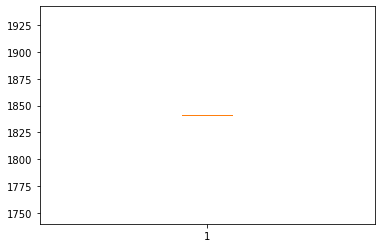

In [17]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('persistence', scores)

Running the example prints the RMSE of the model evaluated using walk-forward validation on the final 12 months of data.

The model is evaluated 30 times, although, because the model has no stochastic element, the score is the same each time.

We can see that the RMSE of the model is 1841, providing a lower-bound of performance by which we can evaluate whether a model is skillful or not on the problem.

## Multilayer Perceptron Model
The first network that we will evaluate is a multilayer Perceptron, or MLP for short.

This is a simple feed-forward neural network model that should be evaluated before more elaborate models are considered.

MLPs can be used for time series forecasting by taking multiple observations at prior time steps, called lag observations, and using them as input features and predicting one or more time steps from those observations.

This is exactly the framing of the problem provided by the series_to_supervised() function in the previous section.

The training dataset is therefore a list of samples, where each sample has some number of observations from months prior to the time being forecasted, and the forecast is the next month in the sequence.

The model will attempt to generalize over these samples, such that when a new sample is provided beyond what is known by the model, it can predict something useful.

We will implement a simple MLP using the Keras deep learning library.

The model will have an input layer with some number of prior observations. This can be specified using the input_dim argument when we define the first hidden layer. The model will have a single hidden layer with some number of nodes, then a single output layer.

We will use the rectified linear activation function on the hidden layer as it performs well. We will use a linear activation function (the default) on the output layer because we are predicting a continuous value.

The loss function for the network will be the mean squared error loss, or MSE, and we will use the efficient Adam flavor of stochastic gradient descent to train the network.

In [18]:
# # Defining a model

# ## Used again later ##

# model = Sequential()
# model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')

The model will be fit for some number of training epochs (exposures to the training data) and batch size can be specified to define how often the weights are updated within each epoch.

The model_fit() function for fitting an MLP model on the training dataset is listed below.

The function expects the config to be a list with the following configuration hyperparameters:

* n_input: The number of lag observations to use as input to the model.
* n_nodes: The number of nodes to use in the hidden layer.
* n_epochs: The number of times to expose the model to the whole training dataset.
* n_batch: The number of samples within an epoch after which the weights are updated.

In [19]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

Making a prediction with a fit MLP model is as straightforward as calling the predict() function and passing in one sample worth of input values required to make the prediction.

In [20]:
# yhat = model.predict(x_input, verbose=0)

In order to make a prediction beyond the limit of known data, this requires that the last n known observations are taken as an array and used as input.

The predict() function expects one or more samples of inputs when making a prediction, so providing a single sample requires the array to have the shape [1, n_input], where n_input is the number of time steps that the model expects as input.

Similarly, the predict() function returns an array of predictions, one for each sample provided as input. In the case of one prediction, there will be an array with one value.

The model_predict() function below implements this behavior, taking the model, the prior observations, and model configuration as arguments, formulating an input sample and making a one-step prediction that is then returned.

In [21]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape(1, n_input)
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

We now have everything we need to evaluate an MLP model on the monthly car sales dataset.

A simple grid search of model hyperparameters was performed and the configuration below was chosen. This may not be an optimal configuration, but is the best that was found.

* n_input: 24 (e.g. 24 months)
* n_nodes: 500
* n_epochs: 100
* n_batch: 100

This configuration can be defined as a list:

In [22]:
# define config
config = [24, 500, 100, 100]

Note that when the training data is framed as a supervised learning problem, there are only 72 samples that can be used to train the model.

Using a batch size of 72 or more means that the model is being trained using batch gradient descent instead of mini-batch gradient descent. This is often used for small datasets and means that weight updates and gradient calculations are performed at the end of each epoch, instead of multiple times within each epoch.

The final code example is listed below.

 > 1432.938
 > 1843.058
 > 1543.240
 > 1434.284
 > 1330.821
 > 1662.517
 > 1495.117
 > 1595.148
 > 1652.232
 > 1604.261
 > 1369.721
 > 1757.340
 > 1643.838
 > 1499.509
 > 1645.081
 > 1495.958
 > 1428.004
 > 1644.123
 > 1398.089
 > 1424.053
 > 1401.247
 > 1660.877
 > 1621.685
 > 1731.454
 > 1611.227
 > 1357.334
 > 1624.653
 > 1583.856
 > 1674.492
 > 1507.997
mlp: 1555.805 RMSE (+/- 127.799)


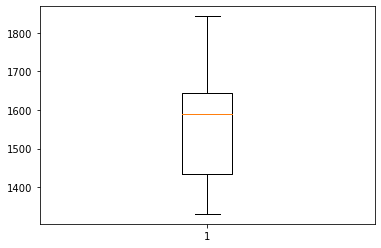

In [23]:
# data split
n_test = 12
# define config
config = [24, 500, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('mlp', scores)

Running the example prints the RMSE for each of the 30 repeated evaluations of the model.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

At the end of the run, the average and standard deviation RMSE are reported of about 1,526 sales.

We can see that, on average, the chosen configuration has better performance than both the naive model (1841.155) and the SARIMA model (1551.842).

This is impressive given that the model operated on the raw data directly without scaling or the data being made stationary.

A box and whisker plot of the RMSE scores is created to summarize the spread of the performance for the model.

This helps to understand the spread of the scores. We can see that although on average the performance of the model is impressive, the spread is large. The standard deviation is a little more than 134 sales, meaning a worse case model run that is 2 or 3 standard deviations in error from the mean error may be worse than the naive model.

A challenge in using the MLP model is in harnessing the higher skill and minimizing the variance of the model across multiple runs.

This problem applies generally for neural networks. There are many strategies that you could use, but perhaps the simplest is simply to train multiple final models on all of the available data and use them in an ensemble when making predictions, e.g. the prediction is the average of 10-to-30 models.

## Convolutional Neural Network Model
Convolutional Neural Networks, or CNNs, are a type of neural network developed for two-dimensional image data, although they can be used for one-dimensional data such as sequences of text and time series.

When operating on one-dimensional data, the CNN reads across a sequence of lag observations and learns to extract features that are relevant for making a prediction.

We will define a CNN with two convolutional layers for extracting features from the input sequences. Each will have a configurable number of filters and kernel size and will use the rectified linear activation function. The number of filters determines the number of parallel fields on which the weighted inputs are read and projected. The kernel size defines the number of time steps read within each snapshot as the network reads along the input sequence.

In [24]:
# model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, 1)))
# model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))

A max pooling layer is used after convolutional layers to distill the weighted input features into those that are most salient, reducing the input size by 1/4. The pooled inputs are flattened to one long vector before being interpreted and used to make a one-step prediction.

In [25]:
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(1))

The CNN model expects input data to be in the form of multiple samples, where each sample has multiple input time steps, the same as the MLP in the previous section.

One difference is that the CNN can support multiple features or types of observations at each time step, which are interpreted as channels of an image. We only have a single feature at each time step, therefore the required three-dimensional shape of the input data will be [n_samples, n_input, 1].

In [26]:
# train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))

The model_fit() function for fitting the CNN model on the training dataset is listed below.

The model takes the following five configuration parameters as a list:

* n_input: The number of lag observations to use as input to the model.
* n_filters: The number of parallel filters.
* n_kernel: The number of time steps considered in each read of the input sequence.
* n_epochs: The number of times to expose the model to the whole training dataset.
* n_batch: The number of samples within an epoch after which the weights are updated.

In [27]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    
    
    # define model
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, 1)))
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    
    
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

Making a prediction with the fit CNN model is very much like making a prediction with the fit MLP model in the previous section.

The one difference is in the requirement that we specify the number of features observed at each time step, which in this case is 1.

The model_predict() function below implements this behavior.

In [28]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

A simple grid search of model hyperparameters was performed and the configuration below was chosen. This is not an optimal configuration, but is the best that was found.

The chosen configuration is as follows:

* n_input: 36 (e.g. 3 years or 3 * 12)
* n_filters: 256
* n_kernel: 3
* n_epochs: 100
* n_batch: 100 (e.g. batch gradient descent)

This can be specified as a list as follows:

In [29]:
# define config
config = [36, 256, 3, 100, 100]

#### ** Since CNNs we have changed so much we will redefine a few functions and run the final code **

In [30]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

In [31]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

 > 1561.774
 > 1485.720
 > 1605.569
 > 1553.368
 > 1498.888
 > 1565.379
 > 1550.313
 > 1739.277
 > 1596.248
 > 1550.621
 > 1582.740
 > 1525.936
 > 1597.707
 > 1513.527
 > 1523.981
 > 1456.616
 > 1553.611
 > 1477.336
 > 1548.517
 > 1484.666
 > 1657.144
 > 1480.622
 > 1562.791
 > 1528.173
 > 1544.949
 > 1450.450
 > 1723.220
 > 1396.058
 > 1619.912
 > 1547.057
cnn: 1549.406 RMSE (+/- 72.540)


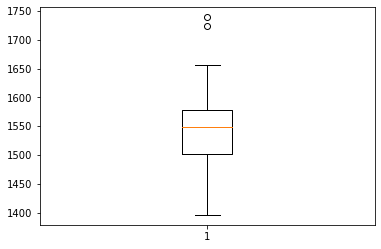

In [32]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [36, 256, 3, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn', scores)

Running the example first prints the RMSE for each repeated evaluation of the model.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

At the end of the run, we can see that indeed the model is skillful, achieving an average RMSE of 1,524.067, which is better than the naive model, the SARIMA model, and even the MLP model in the previous section.

This is impressive given that the model operated on the raw data directly without scaling or the data being made stationary.

The standard deviation of the score is large, at about 57 sales, but is 1/3 the size of the variance observed with the MLP model in the previous section. We have some confidence that in a bad-case scenario (3 standard deviations), the model RMSE will remain below (better than) the performance of the naive model.

A box and whisker plot of the scores is created to help understand the spread of error across the runs.

We can see that the spread does seem to be biased towards larger error values, as we would expect, although the upper whisker of the plot (in this case, the largest error that are not outliers) is still limited at an RMSE of 1,650 sales.

## Recurrent Neural Network Models
Recurrent neural networks, or RNNs, are those types of neural networks that use an output of the network from a prior step as an input in attempt to automatically learn across sequence data.

The Long Short-Term Memory, or LSTM, network is a type of RNN whose implementation addresses the general difficulties in training RNNs on sequence data that results in a stable model. It achieves this by learning the weights for internal gates that control the recurrent connections within each node.

Although developed for sequence data, LSTMs have not proven effective on time series forecasting problems where the output is a function of recent observations, e.g. an autoregressive type forecasting problem, such as the car sales dataset.

Nevertheless, we can develop LSTM models for autoregressive problems and use them as a point of comparison with other neural network models.

In this section, we will explore three variations on the LSTM model for univariate time series forecasting; they are:

* LSTM: The LSTM network as-is.
* CNN-LSTM: A CNN network that learns input features and an LSTM that interprets them.
* ConvLSTM: A combination of CNNs and LSTMs where the LSTM units read input data using the convolutional process of a CNN.

#### LSTM
The LSTM neural network can be used for univariate time series forecasting.

As an RNN, it will read each time step of an input sequence one step at a time. The LSTM has an internal memory allowing it to accumulate internal state as it reads across the steps of a given input sequence.

At the end of the sequence, each node in a layer of hidden LSTM units will output a single value. This vector of values summarizes what the LSTM learned or extracted from the input sequence. This can be interpreted by a fully connected layer before a final prediction is made.

In [33]:
# # define model
# model = Sequential()
# model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
# model.add(Dense(n_nodes, activation='relu'))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')

Like the CNN, the LSTM can support multiple variables or features at each time step. As the car sales dataset only has one value at each time step, we can fix this at 1, both when defining the input to the network in the input_shape argument [n_input, 1], and in defining the shape of the input samples.

In [34]:
# train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))

Unlike the MLP and CNN that do not read the sequence data one-step at a time, the LSTM does perform better if the data is stationary. This means that difference operations are performed to remove the trend and seasonal structure.

In the case of the car sales dataset, we can make the data stationery by performing a seasonal adjustment, that is subtracting the value from one year ago from each observation.

In [35]:
# adjusted = value - value[-12]

This can be performed systematically for the entire training dataset. It also means that the first year of observations must be discarded as we have no prior year of data to difference them with.

The difference() function below will difference a provided dataset with a provided offset, called the difference order, e.g. 12 for one year of months prior.

In [36]:
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

We can make the difference order a hyperparameter to the model and only perform the operation if a value other than zero is provided.

The model_fit() function for fitting an LSTM model is provided below.

The model expects a list of five model hyperparameters; they are:

* n_input: The number of lag observations to use as input to the model.
* n_nodes: The number of LSTM units to use in the hidden layer.
* n_epochs: The number of times to expose the model to the whole training dataset.
* n_batch: The number of samples within an epoch after which the weights are updated.
* n_diff: The difference order or 0 if not used.

In [37]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

Making a prediction with the LSTM model is the same as making a prediction with a CNN model.

A single input must have the three-dimensional structure of samples, timesteps, and features, which in this case we only have 1 sample and 1 feature: [1, n_input, 1].

If the difference operation was performed, we must add back the value that was subtracted after the model has made a forecast. We must also difference the historical data prior to formulating the single input used to make a prediction.

The model_predict() function below implements this behavior.

In [38]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

A simple grid search of model hyperparameters was performed and the configuration below was chosen. This is not an optimal configuration, but is the best that was found.

The chosen configuration is as follows:

* n_input: 36 (i.e. 3 years or 3 * 12)
* n_nodes: 50
* n_epochs: 100
* n_batch: 100 (i.e. batch gradient descent)
* n_diff: 12 (i.e. seasonal difference)

This can be specified as a list:

In [39]:
# define config
config = [36, 50, 100, 100, 12]

 > 2062.126
 > 2186.790
 > 2035.793
 > 2056.314
 > 1926.755
 > 6690.433
 > 2456.020
 > 2164.607
 > 1923.772
 > 2090.001
 > 2013.799
 > 2205.531
 > 2201.914
 > 2038.278
 > 2149.541
 > 2108.095
 > 2041.279
 > 2164.003
 > 2144.136
 > 2080.618
 > 2157.487
 > 2054.618
 > 2176.114
 > 2241.878
 > 1668.358
 > 2395.862
 > 2092.124
 > 1997.976
 > 2218.118
 > 2157.452
lstm: 2263.326 RMSE (+/- 833.805)


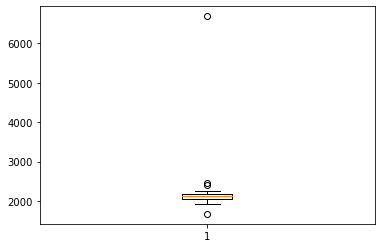

In [40]:
# evaluate lstm
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error
 
n_test = 12
# define config
config = [36, 50, 100, 100, 12]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('lstm', scores)

Running the example, we can see the RMSE for each repeated evaluation of the model.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

At the end of the run, we can see that the average RMSE is about 2,109, which is worse than the naive model. This suggests that the chosen model is not skillful, and it was the best that could be found given the same resources used to find model configurations in the previous sections.

This provides further evidence (although weak evidence) that LSTMs, at least alone, are perhaps a bad fit for autoregressive-type sequence prediction problems.

A box and whisker plot is also created summarizing the distribution of RMSE scores.

Even the base case for the model did not achieve the performance of a naive model.

#### CNN LSTM
We have seen that the CNN model is capable of automatically learning and extracting features from the raw sequence data without scaling or differencing.

We can combine this capability with the LSTM where a CNN model is applied to sub-sequences of input data, the results of which together form a time series of extracted features that can be interpreted by an LSTM model.

This combination of a CNN model used to read multiple subsequences over time by an LSTM is called a CNN-LSTM model.

The model requires that each input sequence, e.g. 36 months, is divided into multiple subsequences, each read by the CNN model, e.g. 3 subsequence of 12 time steps. It may make sense to divide the sub-sequences by years, but this is just a hypothesis, and other splits could be used, such as six subsequences of six time steps. Therefore, this splitting is parameterized with the n_seq and n_steps for the number of subsequences and number of steps per subsequence parameters.

In [42]:
# train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))

The number of lag observations per sample is simply (n_seq * n_steps).

This is a 4-dimensional input array now with the dimensions:

In [43]:
# [samples, subsequences, timesteps, features]

The same CNN model must be applied to each input subsequence.

We can achieve this by wrapping the entire CNN model in a TimeDistributed layer wrapper.

In [44]:
# model = Sequential()
# model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(None,n_steps,1))))
# model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(Flatten()))

The output of one application of the CNN submodel will be a vector. The output of the submodel to each input subsequence will be a time series of interpretations that can be interpreted by an LSTM model. This can be followed by a fully connected layer to interpret the outcomes of the LSTM and finally an output layer for making one-step predictions.

In [45]:
# model.add(LSTM(n_nodes, activation='relu'))
# model.add(Dense(n_nodes, activation='relu'))
# model.add(Dense(1))

The complete model_fit() function is listed below.

The model expects a list of seven hyperparameters; they are:

* n_seq: The number of subsequences within a sample.
* n_steps: The number of time steps within each subsequence.
* n_filters: The number of parallel filters.
* n_kernel: The number of time steps considered in each read of the input sequence.
* n_nodes: The number of LSTM units to use in the hidden layer.
* n_epochs: The number of times to expose the model to the whole training dataset.
* n_batch: The number of samples within an epoch after which the weights are updated.

In [46]:
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(None,n_steps,1))))
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

Making a prediction with the fit model is much the same as the LSTM or CNN, although with the addition of splitting each sample into subsequences with a given number of time steps.

In [47]:
# # prepare data
# x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))

The updated model_predict() function is listed below.

In [48]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

A simple grid search of model hyperparameters was performed and the configuration below was chosen. This may not be an optimal configuration, but it is the best that was found.

* n_seq: 3 (i.e. 3 years)
* n_steps: 12 (i.e. 1 year of months)
* n_filters: 64
* n_kernel: 3
* n_nodes: 100
* n_epochs: 200
* n_batch: 100 (i.e. batch gradient descent)
    
We can define the configuration as a list; for example:

In [52]:
# define config
config = [3, 12, 64, 3, 100, 200, 100]

The complete example of evaluating the CNN-LSTM model for forecasting the univariate monthly car sales is listed below.

 > 1440.583
 > 1381.783
 > 1701.108
 > 1651.295
 > 1385.593
 > 1648.178
 > 1696.665
 > 1608.810
 > 1410.923
 > 1416.501
 > 1815.646
 > 1808.588
 > 1767.160
 > 1345.354
 > 1739.199
 > 1866.840
 > 1897.245
 > 1437.121
 > 1441.194
 > 1810.992
 > 1371.395
 > 1744.355
 > 1884.879
 > 1617.868
 > 1603.904
 > 1826.821
 > 1970.300
 > 1482.590
 > 1840.813
 > 1541.165
cnn-lstm: 1638.496 RMSE (+/- 186.633)


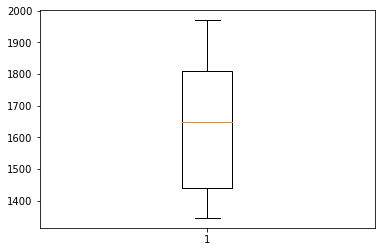

In [53]:
# evaluate cnn lstm
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error
 
# data split
n_test = 12
# # define config
# config = [3, 12, 64, 3, 100, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)

Running the example prints the RMSE for each repeated evaluation of the model.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

The final averaged RMSE is reported at the end of about 1,626, which is lower than the naive model, but still higher than a SARIMA model. The standard deviation of this score is also very large, suggesting that the chosen configuration may not be as stable as the standalone CNN model.

A box and whisker plot is also created summarizing the distribution of RMSE scores.

The plot shows one single outlier of very poor performance just below 3,000 sales.

#### ConvLSTM
It is possible to perform a convolutional operation as part of the read of the input sequence within each LSTM unit.

This means, rather than reading a sequence one step at a time, the LSTM would read a block or subsequence of observations at a time using a convolutional process, like a CNN.

This is different to first reading an extracting features with an LSTM and interpreting the result with an LSTM; this is performing the CNN operation at each time step as part of the LSTM.

This type of model is called a Convolutional LSTM, or ConvLSTM for short. It is provided in Keras as a layer called ConvLSTM2D for 2D data. We can configure it for use with 1D sequence data by assuming that we have one row with multiple columns.

As with the CNN-LSTM, the input data is split into subsequences where each subsequence has a fixed number of time steps, although we must also specify the number of rows in each subsequence, which in this case is fixed at 1.

In [54]:
# train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))

The shape is five-dimensional, with the dimensions:

In [55]:
# [samples, subsequences, rows, columns, features]

Like the CNN, the ConvLSTM layer allows us to specify the number of filter maps and the size of the kernel used when reading the input sequences.

In [56]:
# model.add(ConvLSTM2D(filters=n_filters, kernel_size=(1,n_kernel), activation='relu', input_shape=(n_seq, 1, n_steps, 1)))

The model expects a list of seven hyperparameters, the same as the CNN-LSTM; they are:

* n_seq: The number of subsequences within a sample.
* n_steps: The number of time steps within each subsequence.
* n_filters: The number of parallel filters.
* n_kernel: The number of time steps considered in each read of the input sequence.
* n_nodes: The number of LSTM units to use in the hidden layer.
* n_epochs: The number of times to expose the model to the whole training dataset.
* n_batch: The number of samples within an epoch after which the weights are updated.

    The model_fit() function that implements all of this is listed below.

In [57]:
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=n_filters, kernel_size=(1,n_kernel), activation='relu', input_shape=(n_seq, 1, n_steps, 1)))
    model.add(Flatten())
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

A prediction is made with the fit model in the same way as the CNN-LSTM, although with the additional rows dimension that we fix to 1.

In [58]:
# # prepare data
# x_input = array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))

The model_predict() function for making a single one-step prediction is listed below.

In [59]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

A simple grid search of model hyperparameters was performed and the configuration below was chosen.

This may not be an optimal configuration, but is the best that was found.

* n_seq: 3 (i.e. 3 years)
* n_steps: 12 (i.e. 1 year of months)
* n_filters: 256
* n_kernel: 3
* n_nodes: 200
* n_epochs: 200
* n_batch: 100 (i.e. batch gradient descent)

We can define the configuration as a list; for example:

In [60]:
# define config
config = [3, 12, 256, 3, 200, 200, 100]

We can tie all of this together. The complete code listing for the ConvLSTM model evaluated for one-step forecasting of the monthly car sales dataset is listed below.

* Here I will leave one full example of running code commented so you can see how the pieces we covered fit together

 > 1424.755
 > 1610.239
 > 2284.426
 > 1437.128
 > 1520.626
 > 1509.426
 > 1398.795
 > 1806.837
 > 1312.650
 > 1717.680
 > 2142.703
 > 3501.725
 > 1605.893
 > 1432.310
 > 3040.376
 > 1877.053
 > 1660.665
 > 1770.600
 > 2159.312
 > 1499.895
 > 1706.651
 > 1456.598
 > 2002.638
 > 2206.943
 > 2294.903
 > 2074.153
 > 1745.276
 > 1833.071
 > 1513.797
 > 1619.851
convlstm: 1838.899 RMSE (+/- 476.358)


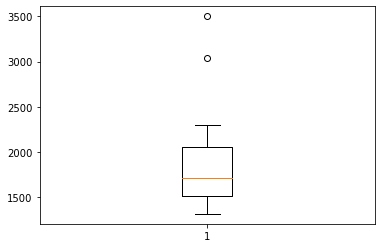

In [61]:
# evaluate convlstm

# # split a univariate dataset into train/test sets
# def train_test_split(data, n_test):
#     return data[:-n_test], data[-n_test:]

# # transform list into supervised learning format
# def series_to_supervised(data, n_in=1, n_out=1):
#     df = DataFrame(data)
#     cols = list()
#     # input sequence (t-n, ... t-1)
#     for i in range(n_in, 0, -1):
#         cols.append(df.shift(i))
#     # forecast sequence (t, t+1, ... t+n)
#     for i in range(0, n_out):
#         cols.append(df.shift(-i))
#     # put it all together
#     agg = concat(cols, axis=1)
#     # drop rows with NaN values
#     agg.dropna(inplace=True)
#     return agg.values

# # root mean squared error or rmse
# def measure_rmse(actual, predicted):
#     return sqrt(mean_squared_error(actual, predicted))

# # difference dataset
# def difference(data, interval):
#     return [data[i] - data[i - interval] for i in range(interval, len(data))]

# # fit a model
# def model_fit(train, config):
#     # unpack config
#     n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
#     n_input = n_seq * n_steps
#     # prepare data
#     data = series_to_supervised(train, n_in=n_input)
#     train_x, train_y = data[:, :-1], data[:, -1]
#     train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
#     # define model
#     model = Sequential()
#     model.add(ConvLSTM2D(filters=n_filters, kernel_size=(1,n_kernel), activation='relu', input_shape=(n_seq, 1, n_steps, 1)))
#     model.add(Flatten())
#     model.add(Dense(n_nodes, activation='relu'))
#     model.add(Dense(1))
#     model.compile(loss='mse', optimizer='adam')
#     # fit
#     model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
#     return model

# # forecast with a pre-fit model
# def model_predict(model, history, config):
#     # unpack config
#     n_seq, n_steps, _, _, _, _, _ = config
#     n_input = n_seq * n_steps
#     # prepare data
#     x_input = array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
#     # forecast
#     yhat = model.predict(x_input, verbose=0)
#     return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# # repeat evaluation of a config
# def repeat_evaluate(data, config, n_test, n_repeats=30):
#     # fit and evaluate the model n times
#     scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
#     return scores

# # summarize model performance
# def summarize_scores(name, scores):
#     # print a summary
#     scores_m, score_std = mean(scores), std(scores)
#     print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
#     # box and whisker plot
#     pyplot.boxplot(scores)
#     pyplot.show()

# series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
# data = series.values
# data split
n_test = 12
# # define config
# config = [3, 12, 256, 3, 200, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('convlstm', scores)

Running the example prints the RMSE for each repeated evaluation of the model.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

The final averaged RMSE is reported at the end of about 1,660, which is lower than the naive model, but still higher than a SARIMA model.

It is a result that is perhaps on par with the CNN-LSTM model. The standard deviation of this score is also very large, suggesting that the chosen configuration may not be as stable as the standalone CNN model.

A box and whisker plot is also created, summarizing the distribution of RMSE scores.

## Extensions
This section lists some ideas for extending the tutorial that you may wish to explore.

* **Data Preparation.** Explore whether data preparation, such as normalization, standardization, and/or differencing can list the performance of any of the models.
* **Grid Search Hyperparameters.** Implement a grid search of the hyperparameters for one model to see if you can further lift performance.
* **Learning Curve Diagnostics.** Create a single fit of one model and review the learning curves on train and validation splits of the dataset, then use the diagnostics of the learning curves to further tune the model hyperparameters in order to improve model performance.
* **History Size.** Explore different amounts of historical data (lag inputs) for one model to see if you can further improve model performance
* **Reduce Variance of Final Model.** Explore one or more strategies to reduce the variance for one of the neural network models.
* **Update During Walk-Forward.** Explore whether re-fitting or updating a neural network model as part of walk-forward validation can further improve model performance.
* **More Parameterization.** Explore adding further model parameterization for one model, such as the use of additional layers.

## Summary
In this tutorial, you discovered how to develop a suite of deep learning models for univariate time series forecasting.

Specifically, you learned:

* How to develop a robust test harness using walk-forward validation for evaluating the performance of neural network models.
* How to develop and evaluate simple multilayer Perceptron and convolutional neural networks for time series forecasting.
* How to develop and evaluate LSTMs, CNN-LSTMs, and ConvLSTM neural network models for time series forecasting.